In [51]:
import pandas as pd

# Adjust the column list to match your CSV structure
# If there's truly an empty column, you can skip it by specifying usecols.
df = pd.read_csv(
    "transactions.csv",
)

df["TimestampStart"] = pd.to_datetime(df["TimestampStart"])
# this is set in utc+0, but i need it in my local timezone
df["TimestampStart"] = (
    df["TimestampStart"].dt.tz_localize("UTC").dt.tz_convert("Europe/Oslo")
)
df["TimestampEnd"] = pd.to_datetime(df["TimestampEnd"])
df["TimestampEnd"] = (
    df["TimestampEnd"].dt.tz_localize("UTC").dt.tz_convert("Europe/Oslo")
)


# convert FullConsumptionKWh to float
df["FullConsumptionKWh"] = df["FullConsumptionKWh"].astype(float)

df["TimestampStart_DAY"] = df["TimestampStart"].dt.day_of_week
df["TimestampStart_HOUR"] = df["TimestampStart"].dt.hour
df["TimestampEnd_DAY"] = df["TimestampEnd"].dt.day_of_week
df["TimestampEnd_HOUR"] = df["TimestampEnd"].dt.hour

df["TimestampStart_MONTH_NAME"] = df["TimestampStart"].dt.month_name()
df["TimestampEnd_MONTH_NAME"] = df["TimestampEnd"].dt.month_name()

df["TimestampStart_MONTH"] = df["TimestampStart"].dt.month

df["TimestampStart_WEEK"] = df["TimestampStart"].dt.isocalendar().week
df.sort_values("TimestampStart_MONTH", inplace=True)


df.head()

,ChargerId,authorizedUserId,TimestampStart,TimestampEnd,FullConsumptionKWh,TimestampStart_DAY,TimestampStart_HOUR,TimestampEnd_DAY,TimestampEnd_HOUR,TimestampStart_MONTH_NAME,TimestampEnd_MONTH_NAME,TimestampStart_MONTH,TimestampStart_WEEK
0,ZCS001661,-1,2025-01-20 11:50:09.590000+01:00,2025-01-20 15:37:55.197000+01:00,34.556,0,11,0,15,January,January,1,4
137401,ECLTJJPL,46216,2025-01-01 17:12:24+01:00,2025-01-02 11:36:26+01:00,52.176,2,17,3,11,January,January,1,1
137402,ECYHCBTM,37520,2025-01-02 09:47:04+01:00,2025-01-02 11:36:05+01:00,4.642,3,9,3,11,January,January,1,1
137404,ECN5WBRH,48008,2025-01-01 15:29:08+01:00,2025-01-02 11:35:25+01:00,45.552,2,15,3,11,January,January,1,1
137405,EC32M8VQ,47690,2025-01-01 17:07:45+01:00,2025-01-02 11:35:12+01:00,5.928,2,17,3,11,January,January,1,1


Text(1066.1767676767674, 0.5, 'Time')

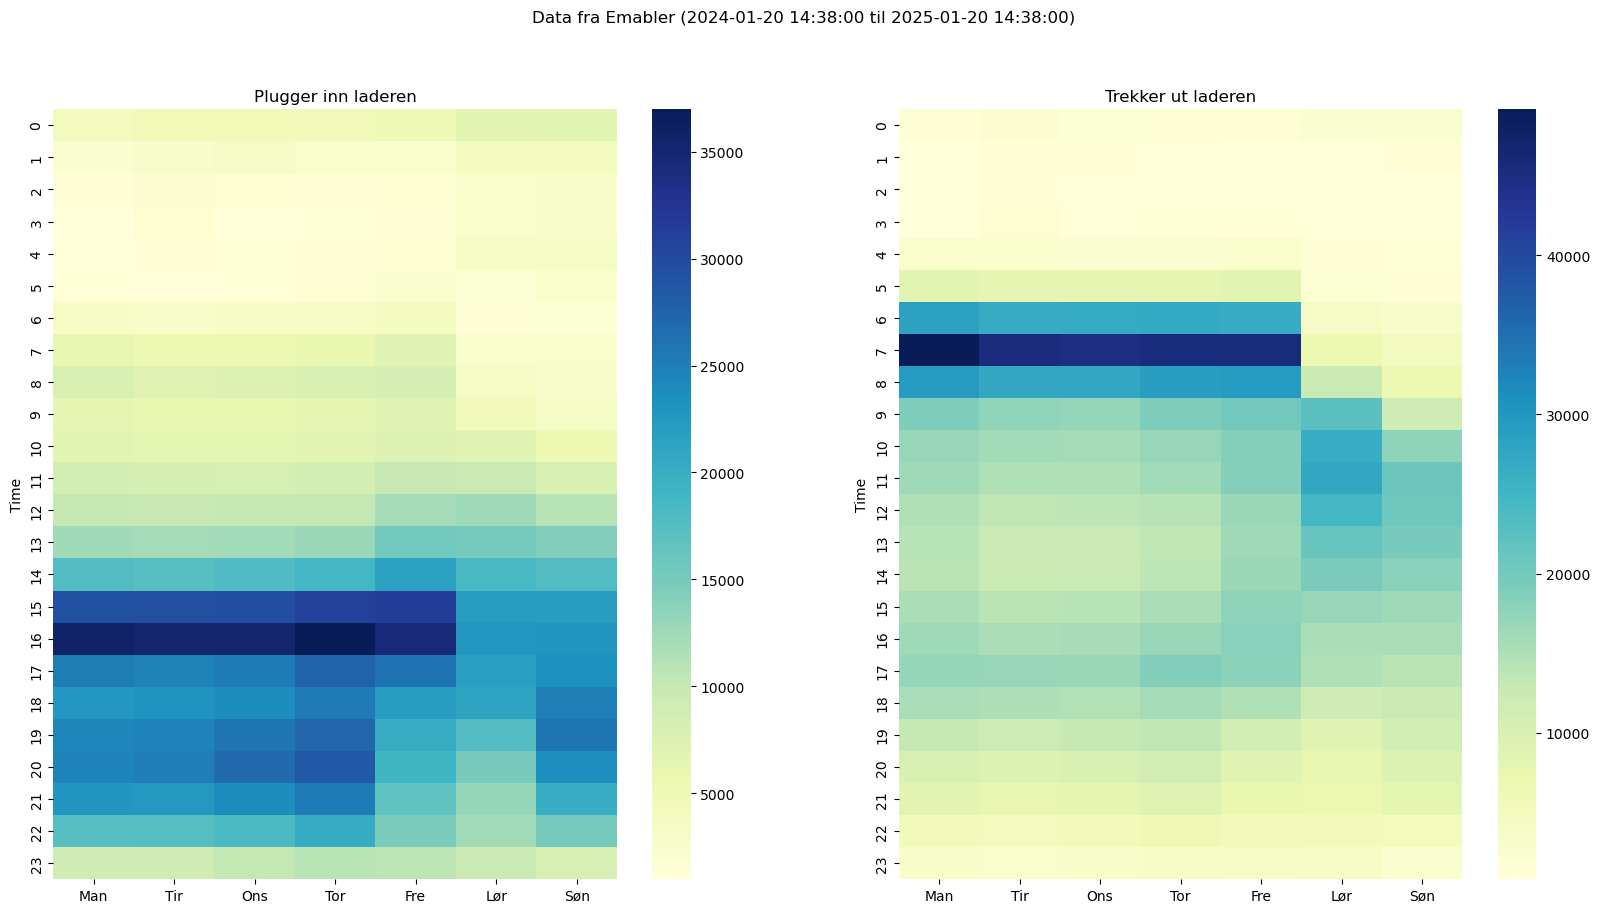

In [52]:



# show a heatmat of when people start charging and when they stop charging

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

fig.suptitle("Data fra Emabler (2024-01-20 14:38:00 til 2025-01-20 14:38:00)")

sns.heatmap(
    df.groupby(["TimestampStart_DAY", "TimestampStart_HOUR"]).size().unstack().T,
    ax=ax[0],
    cmap="YlGnBu",
    cbar=True,
    xticklabels=["Man", "Tir", "Ons", "Tor", "Fre", "Lør", "Søn"],
    yticklabels=range(24),
    fmt="d",
    annot=False,
)
ax[0].set_title("Plugger inn laderen")
ax[0].set_xlabel("")
ax[0].set_ylabel("Time")

sns.heatmap(
    df.groupby(["TimestampEnd_DAY", "TimestampEnd_HOUR"]).size().unstack().T,
    ax=ax[1],
    cmap="YlGnBu",
    cbar=True,
    xticklabels=["Man", "Tir", "Ons", "Tor", "Fre", "Lør", "Søn"],
    yticklabels=range(24),
    fmt="d",
    annot=False,
)
ax[1].set_title("Trekker ut laderen")
ax[1].set_xlabel("")
ax[1].set_ylabel("Time")

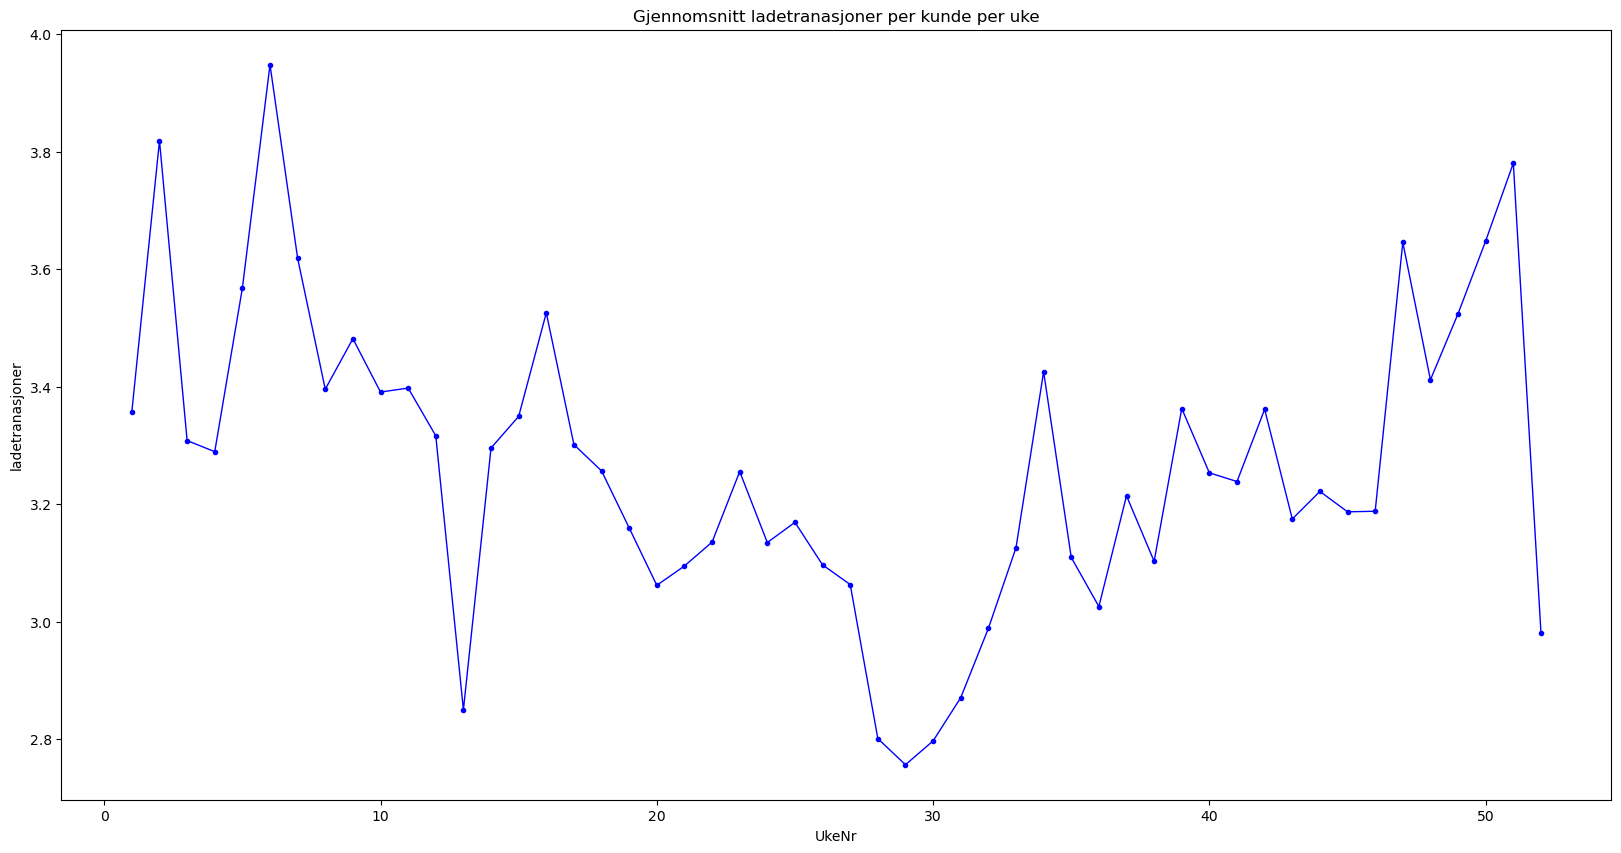

In [53]:
# show a plot showing how many charging transactions a unique chargerId has in a week

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

xy = df.groupby(["authorizedUserId", "TimestampStart_WEEK"]).size().unstack().T

# remove authorizedUserId with id = -1
xy = xy.drop(-1, axis=1)



# find mean of all chargerIds for each week
xy = xy.mean(axis=1)



xy.plot(
    ax=ax, legend=False, color="blue", marker="o", linestyle="-", linewidth=1, markersize=3
)

ax.set_title("Gjennomsnitt ladetranasjoner per kunde per uke")
ax.set_xlabel("UkeNr")
ax.set_ylabel("ladetranasjoner")
plt.show()


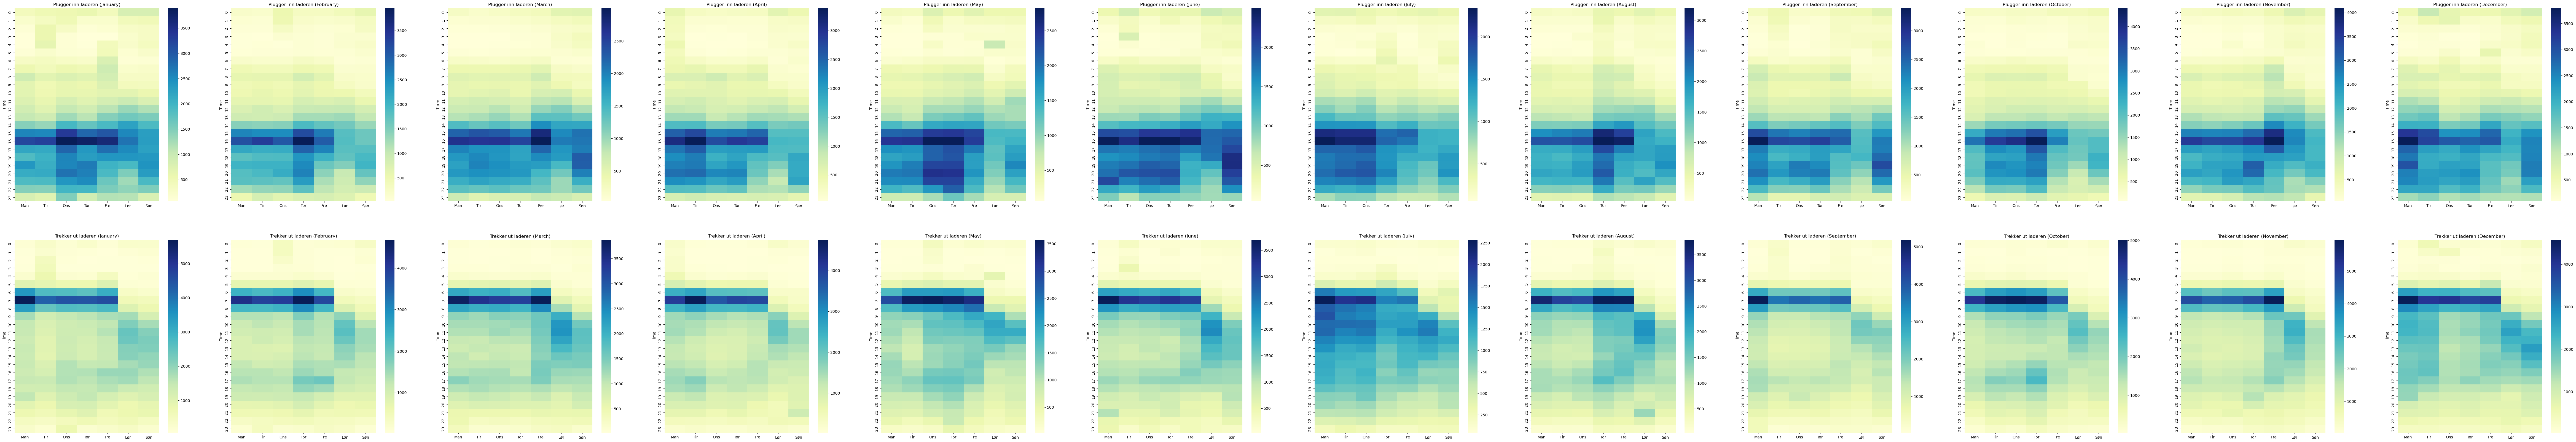

In [54]:

# make the same heatmap but for each month
fig, ax = plt.subplots(2, 12, figsize=(120, 20))

for i, month in enumerate(df["TimestampStart_MONTH_NAME"].unique()):
    sns.heatmap(
        df[df["TimestampStart_MONTH_NAME"] == month]
        .groupby(["TimestampStart_DAY", "TimestampStart_HOUR"])
        .size()
        .unstack()
        .T,
        ax=ax[0, i],
        cmap="YlGnBu",
        cbar=True,
        xticklabels=["Man", "Tir", "Ons", "Tor", "Fre", "Lør", "Søn"],
        yticklabels=range(24),
    )
    ax[0, i].set_title(f"Plugger inn laderen ({month})")
    ax[0, i].set_xlabel("")
    ax[0, i].set_ylabel("Time")

    sns.heatmap(
        df[df["TimestampEnd_MONTH_NAME"] == month]
        .groupby(["TimestampEnd_DAY", "TimestampEnd_HOUR"])
        .size()
        .unstack()
        .T,
        ax=ax[1, i],
        cmap="YlGnBu",
        cbar=True,
        xticklabels=["Man", "Tir", "Ons", "Tor", "Fre", "Lør", "Søn"],
        yticklabels=range(24),
    )
    ax[1, i].set_title(f"Trekker ut laderen ({month})")
    ax[1, i].set_xlabel("")
    ax[1, i].set_ylabel("Time")